<a href="https://colab.research.google.com/github/jamslaugh/My-Datascience-Projects/blob/master/house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"randomcluster","key":"c11f4b3b630cb22dab26811652171286"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3033            True  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11261            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4721            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         38           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3189           False  
recognizing-faces-in-the-wild                      2019-08-01 23:59:00  Playground       Knowledge      

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score,mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import Imputer,LabelEncoder, StandardScaler
from sklearn.neighbors import KernelDensity # To estimate outliers in first instance
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques --force

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.1MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.4MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.0MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.2MB/s]


In [ ]:
# Defining Train, Test and so on. Remember that Test has no labels. So, we need to split train data in validation set. 
# So our schedule is as follows:
# 1) create a first, untuned, case. Then propose an innovation

trdata = pd.read_csv("train.csv",index_col='Id')
tedata = pd.read_csv("test.csv",index_col='Id')

In [ ]:
print(trdata.head(10))
print(tedata.head(10))

    MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                    ...                                  
1           60       RL         65.0  ...        WD        Normal    208500
2           20       RL         80.0  ...        WD        Normal    181500
3           60       RL         68.0  ...        WD        Normal    223500
4           70       RL         60.0  ...        WD       Abnorml    140000
5           60       RL         84.0  ...        WD        Normal    250000
6           50       RL         85.0  ...        WD        Normal    143000
7           20       RL         75.0  ...        WD        Normal    307000
8           60       RL          NaN  ...        WD        Normal    200000
9           50       RM         51.0  ...        WD       Abnorml    129900
10         190       RL         50.0  ...        WD        Normal    118000

[10 rows x 80 columns]
      MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType Sal

In [ ]:
print((trdata.isna().sum()/trdata.shape[0]*100))

MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
                   ...    
BedroomAbvGr      0.000000
KitchenAbvGr      0.000000
KitchenQual       0.000000
TotRmsAbvGrd      0.000000
Functional        0.000000
Fireplaces        0.000000
F

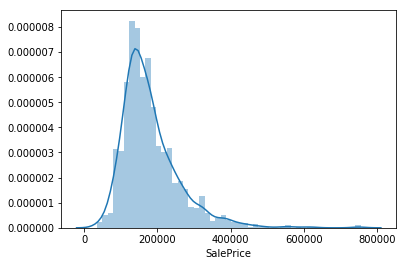

In [ ]:
sns.distplot(trdata.SalePrice)

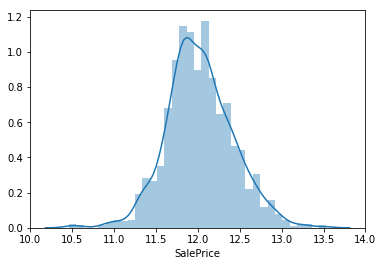

In [ ]:
sns.distplot(np.log(trdata.SalePrice+1))

In [ ]:
trdata['Target'] = np.log(trdata.SalePrice+1)
trdatad = trdata.drop('SalePrice',axis=1)
trdatad.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [ ]:
Y = trdatad.Target
trdatad.drop('Target',inplace=True,axis=1)

In [ ]:
data = pd.concat([trdatad,tedata],axis = 0)

In [ ]:
def plot_null(df_train):
  label_nas = []
  for col in df_train.columns.tolist():
      if np.sum(df_train[col].isnull() ) != 0:
          label_nas.append(col)
      else:
          label_nas.append("")

  plt.figure(figsize=(12,7))
  plt.suptitle('Missing Values in the Training Set')
  sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='CMRmap')
  plt.show()

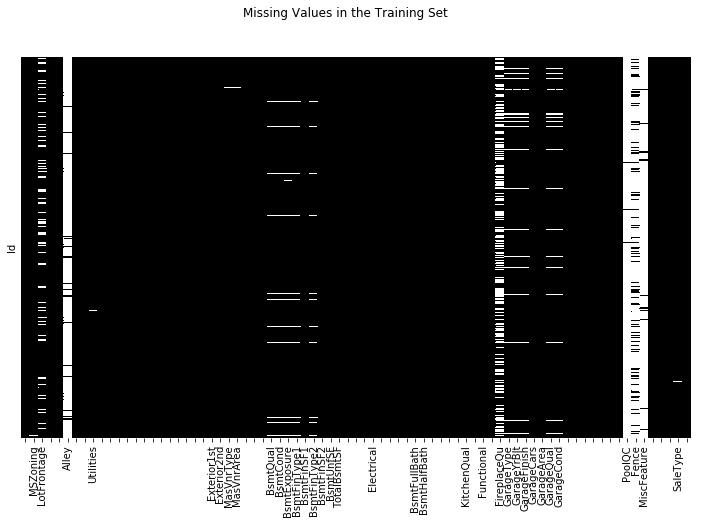

In [ ]:
plot_null(data)

In [ ]:
data_keep = (data.isna().sum()/data.shape[0]*100<20)

In [ ]:
col_keep=data_keep.loc[data_keep==False].index.tolist()

In [ ]:
data = data.drop(col_keep,axis = 1)

In [ ]:
col_num = [k for k in data.columns if data[k].dtypes !='object']
col_obj = [k for k in data.columns if data[k].dtypes =='object']


In [ ]:
print(col_num)
print(col_obj)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleT

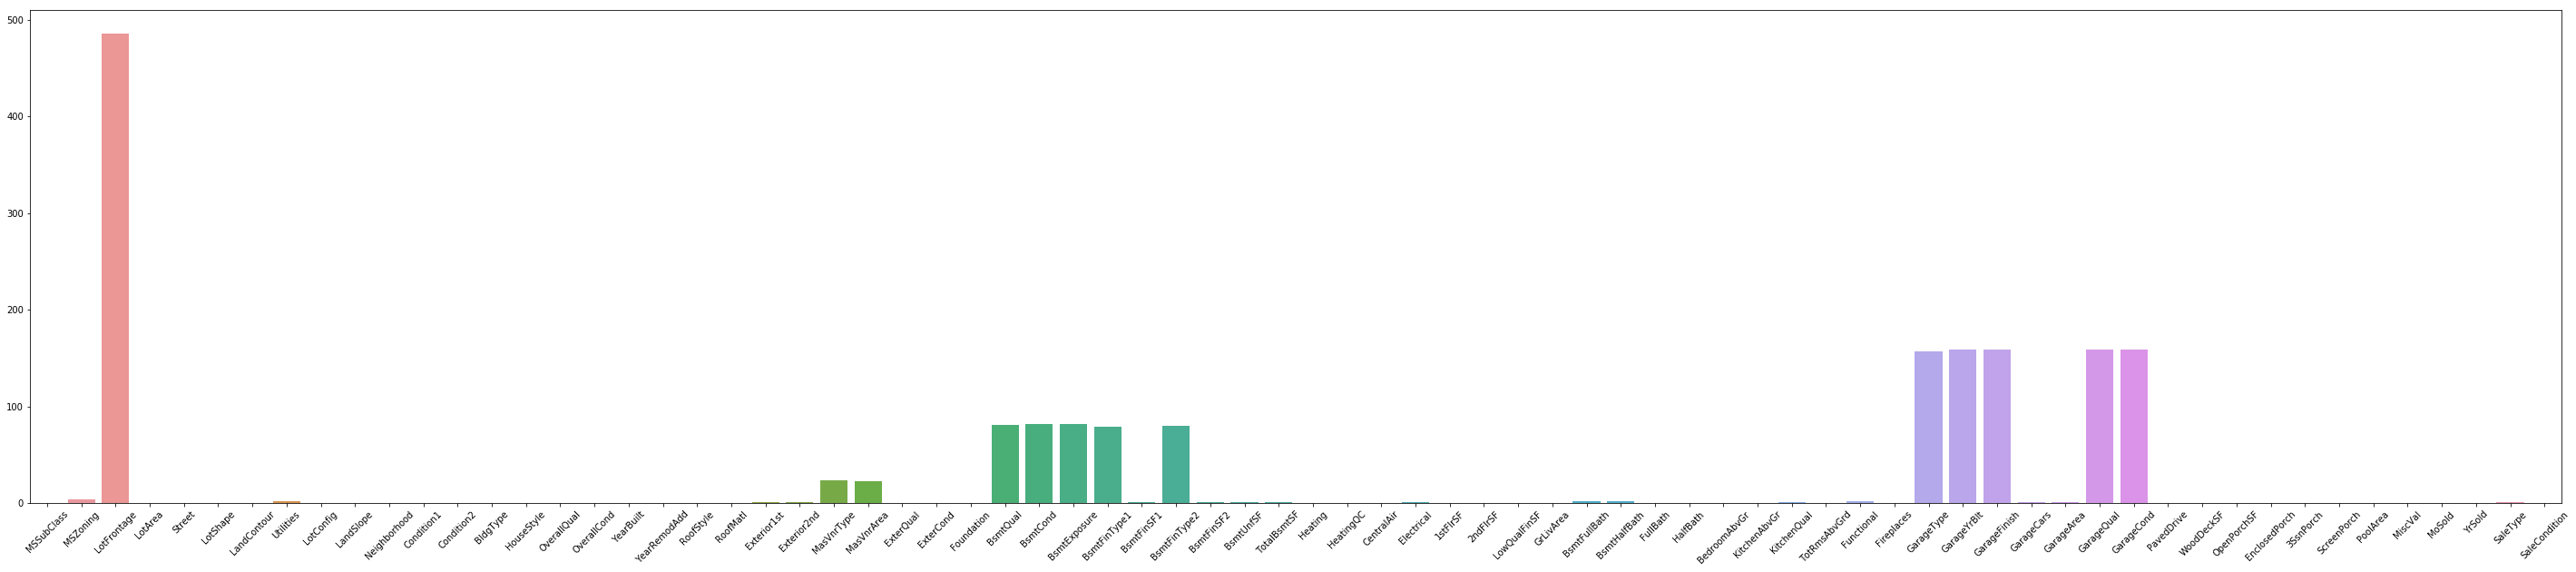

In [ ]:
plt.figure(figsize=(50,10))
_ = sns.barplot(data.columns,data.isna().sum())
plt.xticks(rotation=45)
plt.show()

In [ ]:
data.isna().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          2
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          81
BsmtCond          82
                ... 
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        1
TotRmsAbvGrd       0
Functional         2
Fireplaces         0
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual   

In [ ]:
data[col_num].dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
dtype: object

In [ ]:
# Let's clean our values. First, get most common value for objects!

for col in col_obj:
  data[col] = data[col].fillna(data[col].value_counts().index[0])

print(data[col_obj].isna().sum())

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64


trdatad.shape

In [ ]:
data[col_num].apply(lambda x: np.max(x))

MSSubClass          190.0
LotFrontage         313.0
LotArea          215245.0
OverallQual          10.0
OverallCond           9.0
YearBuilt          2010.0
YearRemodAdd       2010.0
MasVnrArea         1600.0
BsmtFinSF1         5644.0
BsmtFinSF2         1526.0
BsmtUnfSF          2336.0
TotalBsmtSF        6110.0
1stFlrSF           5095.0
2ndFlrSF           2065.0
LowQualFinSF       1064.0
GrLivArea          5642.0
BsmtFullBath          3.0
BsmtHalfBath          2.0
FullBath              4.0
HalfBath              2.0
BedroomAbvGr          8.0
KitchenAbvGr          3.0
TotRmsAbvGrd         15.0
Fireplaces            4.0
GarageYrBlt        2207.0
GarageCars            5.0
GarageArea         1488.0
WoodDeckSF         1424.0
OpenPorchSF         742.0
EnclosedPorch      1012.0
3SsnPorch           508.0
ScreenPorch         576.0
PoolArea            800.0
MiscVal           17000.0
MoSold               12.0
YrSold             2010.0
dtype: float64

In [ ]:
data[col_num].apply(lambda x: np.min(x))

MSSubClass         20.0
LotFrontage        21.0
LotArea          1300.0
OverallQual         1.0
OverallCond         1.0
YearBuilt        1872.0
YearRemodAdd     1950.0
MasVnrArea          0.0
BsmtFinSF1          0.0
BsmtFinSF2          0.0
BsmtUnfSF           0.0
TotalBsmtSF         0.0
1stFlrSF          334.0
2ndFlrSF            0.0
LowQualFinSF        0.0
GrLivArea         334.0
BsmtFullBath        0.0
BsmtHalfBath        0.0
FullBath            0.0
HalfBath            0.0
BedroomAbvGr        0.0
KitchenAbvGr        0.0
TotRmsAbvGrd        2.0
Fireplaces          0.0
GarageYrBlt      1895.0
GarageCars          0.0
GarageArea          0.0
WoodDeckSF          0.0
OpenPorchSF         0.0
EnclosedPorch       0.0
3SsnPorch           0.0
ScreenPorch         0.0
PoolArea            0.0
MiscVal             0.0
MoSold              1.0
YrSold           2006.0
dtype: float64

In [ ]:
for i in [0,0.25,0.5,0.75,1]:
  print("This is quantle @ %s and has \n%s"%(str(i),data[col_num].apply(lambda x: np.quantile(x,q=i))))
  

This is quantle @ 0 and has 
MSSubClass         20.0
LotFrontage         NaN
LotArea          1300.0
OverallQual         1.0
OverallCond         1.0
YearBuilt        1872.0
YearRemodAdd     1950.0
MasVnrArea          NaN
BsmtFinSF1          NaN
BsmtFinSF2          NaN
BsmtUnfSF           NaN
TotalBsmtSF         NaN
1stFlrSF          334.0
2ndFlrSF            0.0
LowQualFinSF        0.0
GrLivArea         334.0
BsmtFullBath        NaN
BsmtHalfBath        NaN
FullBath            0.0
HalfBath            0.0
BedroomAbvGr        0.0
KitchenAbvGr        0.0
TotRmsAbvGrd        2.0
Fireplaces          0.0
GarageYrBlt         NaN
GarageCars          NaN
GarageArea          NaN
WoodDeckSF          0.0
OpenPorchSF         0.0
EnclosedPorch       0.0
3SsnPorch           0.0
ScreenPorch         0.0
PoolArea            0.0
MiscVal             0.0
MoSold              1.0
YrSold           2006.0
dtype: float64
This is quantle @ 0.25 and has 
MSSubClass         20.0
LotFrontage         NaN
LotArea     

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [ ]:
def detect_outlier(data_1, threshold = 3):
  outliers = []
  sd_data = np.std(data_1)
  mu_data = np.mean(data_1)
  
  
  
  for y in data_1:
    z_score = (y-mu_data)/sd_data
    if np.abs(z_score)>threshold:
      outliers.append(y)
  
  return sorted(outliers,reverse=True)

In [ ]:
outliers = dict(data[col_num].apply(lambda x : detect_outlier(x,threshold=5)))

In [ ]:
outliers

{'1stFlrSF': [5095.0, 4692.0, 3820.0, 3228.0, 3138.0],
 '2ndFlrSF': [],
 '3SsnPorch': [508.0,
  407.0,
  360.0,
  323.0,
  320.0,
  304.0,
  290.0,
  255.0,
  245.0,
  238.0,
  225.0,
  224.0,
  219.0,
  216.0,
  216.0,
  196.0,
  182.0,
  180.0,
  180.0,
  176.0,
  174.0,
  168.0,
  168.0,
  168.0,
  162.0,
  153.0,
  153.0,
  153.0,
  150.0,
  144.0,
  144.0,
  140.0,
  130.0],
 'BedroomAbvGr': [8.0],
 'BsmtFinSF1': [5644.0, 4010.0],
 'BsmtFinSF2': [1526.0,
  1474.0,
  1393.0,
  1164.0,
  1127.0,
  1120.0,
  1085.0,
  1083.0,
  1080.0,
  1073.0,
  1063.0,
  1061.0,
  1057.0,
  1039.0,
  1037.0,
  1031.0,
  1029.0,
  1020.0,
  982.0,
  981.0,
  972.0,
  956.0,
  955.0,
  915.0,
  912.0,
  906.0,
  904.0],
 'BsmtFullBath': [],
 'BsmtHalfBath': [2.0, 2.0, 2.0, 2.0],
 'BsmtUnfSF': [],
 'EnclosedPorch': [1012.0, 584.0, 552.0, 432.0, 429.0, 386.0, 368.0, 364.0],
 'Fireplaces': [4.0],
 'FullBath': [],
 'GarageArea': [],
 'GarageCars': [],
 'GarageYrBlt': [2207.0],
 'GrLivArea': [5642.0, 509

In [ ]:
idx = data[data.GrLivArea>4000].index
idx_y = [k for k in idx if k<1461]
Y=Y.drop(idx_y)
data=data.drop(labels=idx_y,axis=0)
#Y=Y.drop(idx)

In [ ]:
# we have at keast one outlier! Moreover, year and year remod might intend if the house has been restructured.


data['Restructured'] = np.where(data['YearBuilt']!=data['YearRemodAdd'],1,0)

In [ ]:
for col in col_num:
   data[col] = data[col].fillna(data[col].median())

In [ ]:
print(data.isna().sum())

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch   

In [ ]:
data = pd.concat([pd.get_dummies(data[col_obj],drop_first=True),data.drop(col_obj,axis=1)],axis=1)

In [ ]:
cor_mat=pd.concat([Y,data.loc[:1460,:]],axis=1).corr()

In [ ]:
data.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,...,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Restructured
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,0
2,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,0
3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,1
4,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,1
5,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,0


In [ ]:
#plt.figure(figsize=(50,50))
#sns.heatmap(cor_mat*np.tril(np.ones((cor_mat.shape[0],cor_mat.shape[0]))),cmap='Blues',annot=True,linewidths=1)
#plt.show()

In [ ]:
X_tr,X_te = data.loc[0:1460,:],data.loc[1461:,:]

In [ ]:
idx_to_suppress = np.random.randint(X_te.index.min(),X_te.index.max(),size=2)

In [ ]:
#recover,X_te = X_te.loc[idx_to_suppress,:], X_te.drop(idx_to_suppress,axis=0)


In [ ]:
X_te.shape

(1459, 232)

In [ ]:
#mms = MinMaxScaler(feature_range=(0,1))
#trdatad = mms.fit_transform(trdatad)

In [ ]:
from xgboost import XGBRegressor
shrink = XGBRegressor()
shrink.fit(X_tr,Y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [ ]:
from sklearn.feature_selection import SelectFromModel
selection = SelectFromModel(shrink,threshold=0.001,prefit=True)
Xtr = selection.transform(X_tr)
Xte = selection.transform(X_te)

In [ ]:
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)
Xte = scaler.transform(Xte)
X_te_norm = scaler.fit_transform(X_te)
X_tr_norm = scaler.transform(X_tr)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(Xtr,Y,test_size=0.2)

In [ ]:
reg = SVR(C=4,gamma=5)
reg.fit(x_train,y_train)
pred=reg.predict(x_test)

In [ ]:
print("MAE is :",mean_absolute_error(y_test,pred))
print("MSE is :",mean_squared_error(y_test,pred))
print("MSLE is :",mean_squared_log_error(y_test,pred))

MAE is : 0.30595309555707667
MSE is : 0.16159438034374224
MSLE is : 0.0009490389569818026


In [ ]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv1D, LeakyReLU, Flatten,Reshape,MaxPooling1D, BatchNormalization, Activation
import tensorflow as tf
from keras.callbacks import History, EarlyStopping
from keras.regularizers import l1,l2
from keras import backend as K
from keras.optimizers import Adadelta,Adam, RMSprop

hist = History()

Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(Dense(500, kernel_initializer = "glorot_normal",input_shape=(Xtr.shape[1],)))
model.add(BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001, center=True, scale=False, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

#model.add(Reshape(input_shape=(200,), target_shape=(200, 1)))
#model.add(Conv1D(1000,activation='relu', kernel_initializer = "VarianceScaling",kernel_size=15,activity_regularizer=l2(l=0.001)))
#model.add(MaxPooling1D(pool_size=30,strides=2))
#model.add(Conv1D(100,activation='relu', kernel_initializer = "VarianceScaling",kernel_size=20))
#model.add(MaxPooling1D(pool_size=30,strides=2))
#model.add(LeakyReLU())
#model.add(Flatten())
#model.add(Dropout(rate=0.7))
model.add(Dense(200, kernel_initializer = "glorot_normal"))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.00003, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Activation('relu'))
model.add(Dropout(rate=0.52))
model.add(Dense(80, kernel_initializer = "VarianceScaling"))
model.add(BatchNormalization(axis=-1, momentum=0.999, epsilon=0.00003, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Activation('relu'))
#model.add(Dense(100,activation='relu', kernel_initializer = "VarianceScaling"))
#model.add(BatchNormalization(axis=-1, momentum=0.999, epsilon=0.00001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dropout(rate=0.54))
#model.add(Dense(50,activation='relu', kernel_initializer = "VarianceScaling"))
#model.add(Dropout(rate=0.7))
model.add(Dense(20, kernel_initializer = "glorot_normal"))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.00003, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Activation('relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(1,kernel_initializer='glorot_normal',activation='linear'))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 500)               40000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 500)               1500      
_________________________________________________________________
activation_5 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 200)               800       
_________________________________________________________________
activation_6 (Activation)    (None, 200)               0         
__________

In [ ]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(np.float128(y_pred - y_true)), axis=-1)) 

model.compile(optimizer=Adam(lr=0.0001,beta_1=0.92,beta_2=0.9995,decay=1e-7),loss='mean_squared_error',metrics=['mean_absolute_error'])
model.fit(Xtr,Y,epochs=300,callbacks=[hist])

Epoch 1/300
1456/1456 [==============================] - 1s 1ms/step - loss: 160.0978 - mean_absolute_error: 12.6033
Epoch 2/300
1456/1456 [==============================] - 0s 263us/step - loss: 159.5587 - mean_absolute_error: 12.5825
Epoch 3/300
1456/1456 [==============================] - 0s 252us/step - loss: 158.4123 - mean_absolute_error: 12.5417
Epoch 4/300
1456/1456 [==============================] - 0s 271us/step - loss: 157.0045 - mean_absolute_error: 12.4862
Epoch 5/300
1456/1456 [==============================] - 0s 255us/step - loss: 154.5883 - mean_absolute_error: 12.3926
Epoch 6/300
1456/1456 [==============================] - 0s 255us/step - loss: 154.2434 - mean_absolute_error: 12.3784
Epoch 7/300
1456/1456 [==============================] - 0s 264us/step - loss: 152.1940 - mean_absolute_error: 12.2934
Epoch 8/300
1456/1456 [==============================] - 0s 259us/step - loss: 150.4544 - mean_absolute_error: 12.2225
Epoch 9/300
1456/1456 [===========================

In [ ]:
ind = np.ndarray.tolist(np.unique(np.random.randint(0,Y.shape[0],size=400)))
model.evaluate(x_train,y_train)

1164/1164 [==============================] - 0s 163us/step


[7.329877455209949, 2.4911656289575848]

In [ ]:
[len(el) for el in model.get_weights()]

[79, 200, 200, 100, 100, 50, 50, 20, 20, 1]

In [ ]:
0.0062846**(1/2)


0.07927546909353486

KeyError: ignored

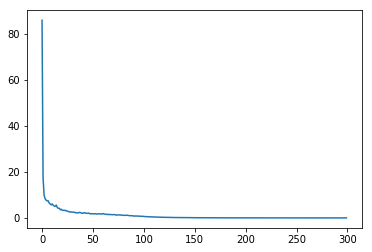

In [ ]:
plt.figure()
plt.plot(hist.history['loss'],label='Train')
plt.plot(hist.history['val_loss'],label='Validation')
plt.legend()
plt.show()

In [ ]:
model.save_weights('a_facc_ro_Cazz.HDF5')
files.download('a_facc_ro_Cazz.HDF5')

# if you need to reload, reload nice.HDF5, which is in the Downloads folder, with files.upload()

In [ ]:
tot=np.exp(model.predict(Xte))


In [ ]:
model.predict(Xte).shape

In [ ]:
tot.shape

In [ ]:
np.std(tot)

27511.771

In [ ]:
np.std(np.exp(Y))

76670.24989058502

In [ ]:
#submit_data = np.array(Id_col.reshape((Id_col.shape[0],1)),tot)
x = np.random.randn(5)
y = np.sin(x)



In [ ]:
Id_col = X_te.index.to_numpy()
np.delete(Id_col,idx_to_suppress)
pd.DataFrame.from_dict({'Id':Id_col,'SalePrice':tot.reshape(tot.shape[0],)}).to_csv('submission.csv',index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


In [ ]:
files.download('submission.csv')

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 21.0k/21.0k [00:01<00:00, 11.8kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques

In [ ]:
!pip install catboost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
tr_data,te_data = data.loc[0:1460,:], data.loc[1461:,:]

In [ ]:
precat_data = trdata.drop(idx_y)
precat_data.drop(col_keep,inplace=True,axis=1)

In [ ]:
precat_data.drop(['SalePrice','Target'],inplace = True,axis=1)

In [ ]:
for col in col_obj:
  precat_data[col] = precat_data[col].fillna(precat_data[col].value_counts().index[0])

for col in col_num:
  precat_data[col] = precat_data[col].fillna(precat_data[col].median())
  
print(precat_data[col_obj].isna().sum())

In [ ]:
cat_features = np.where(precat_data.dtypes == 'object')[0]

In [ ]:
cat_data = Pool(precat_data,Y,cat_features=cat_features)

In [ ]:
reg1 = CatBoostRegressor(iterations=5000,fold_len_multiplier=3,bagging_temperature=10)

In [ ]:
reg1.fit(cat_data)

In [ ]:
cat_datate = tedata.drop(col_keep,axis=1)
for col in col_obj:
  cat_datate[col] = cat_datate[col].fillna(cat_datate[col].value_counts().index[0])

for col in col_num:
  cat_datate[col] = cat_datate[col].fillna(cat_datate[col].median())

In [ ]:
indices = [i for i,k in enumerate(np.ndarray.tolist(np.int32(reg1.feature_importances_>0.1))) if k==1]

In [ ]:
pred_def=np.exp(reg1.predict(cat_datate))

In [ ]:
np.std(pred_def)

In [ ]:
Id_col = X_te.index.to_numpy()
np.delete(Id_col,idx_to_suppress)
pd.DataFrame.from_dict({'Id':Id_col,'SalePrice':pred_def.reshape(pred_def.shape[0],)}).to_csv('submission.csv',index=False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

In [ ]:
data.columns

In [ ]:
#Next on, but before, better go on first dataset still. NN is most viable.... !kaggle competitions download -c zillow-prize-1

In [ ]:
import tensorflow as tf

a_G = tf.random_normal([2,4,4,5],mean=1,stddev=2)

In [ ]:
a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)

In [ ]:
a_C.shape.as_list()

[1, 4, 4, 3]

In [ ]:
m,n_H,n_W,n_C =a_G.shape

In [ ]:
tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))

<tf.Tensor 'Sum_2:0' shape=() dtype=float32>

In [ ]:
GS = tf.matmul(tf.reshape(a_C,(n_C,n_H*n_W)),tf.transpose(tf.reshape(a_C,(n_C,n_H*n_W))))
GG = tf.matmul(tf.reshape(a_G,(n_C,n_H*n_W)),tf.transpose(tf.reshape(a_G,(n_C,n_H*n_W))))

In [ ]:
tf.math.reduce_sum(np.array([[1,1,1],[1,1,1]]))

AttributeError: ignored